### Controlling the closed-loop poles 

One of the most powerful facts of state-feedback control is that if the system is controllable, the closed-loop poles of the system can be arbitrarily placed (using Ackermann equation). The selected pole values will decide the response of the system and they can be fine tuned for a desired response. 

The illustration below allows the user to pick desired poles and see the effect on the response of the system. 

In [10]:
%matplotlib notebook    
import numpy as np
import scipy.integrate as integrate
import control.matlab as co
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation 
from matplotlib.widgets import Slider
from matplotlib.widgets import Button

In [11]:
def statespace(y,t):
    
    """ Creates State vector from given initial conditions.
        State Linear vector follows the equation Xdot = AX. This function creates the vector using
        the dynamic model of the system. This vector is passed through scipy.integrate.odeint functin
        which will integrate the vector and output states similar to ode45 in MATLAB.
        
        inputs:
            y = state vector that will be calculated by odeint
            t = time vector
            
        returns:
            dydt = State Vector
    
    Note: The dynamic model of the system is referred from Prof. Steven L. Brunton's youtube series Control Bootcamp.
    """
    
    Sy = np.sin(y[2])           # Assigning a variable for sin theta for simplicity in writing equations
    Cy = np.cos(y[2])           # Assigning a variable for sin theta for simplicity in writing equations
    #D = m*L*L*(M+m*(1-Cy**2))   # Denominator of the equations of motion
    D = (M+m)*(I+m*L**2) - m**2*L**2*Cy**2
    dydt = np.zeros_like(y)     # Creating dydt vector same size/shape as y
    
    """ Arrays and matrices are treated differently in numpy and therefore need to be treated differently. 
    We need to calculate the input u to the states and therefore need to convert the vectors to the same data type 
    before proceeding"""
    
    y_mat = np.matrix([[y[0]],[y[1]],[y[2]],[y[3]]])     
    
    inp = -Kf*(y_mat-yd_mat)
    u = inp[0,0] # We cannot directly use inp to multiply in the equations and need to extract it from the 1x1 inp matrix
    
    # State Equations
    dydt[0] = y[1]
    dydt[1] = (1/D)*(-m**2*L**2*g*Cy*Sy + m*L**2*(m*L*y[3]**2*Sy - d*y[1])) + m*L*L*(1/D)*u
    dydt[2] = y[3]
    dydt[3] = (1/D)*((m+M)*m*g*L*Sy - m*L*Cy*(m*L*y[3]**2*Sy - d*y[1])) - m*L*Cy*(1/D)*u 
    
    
    return dydt

In [12]:
def update_button(i):
   
    global p1,p2,p3,p4,Kf,y #Global so that the updated versions can be accessed in other functions.
    
    #theta = s_th.val   # Assigning the new theta value from the slider
    #xx = s_xx.val      # Assigning the x-position of the cart
    #ani.event_source.start(1)
    p1 = s_p1.val
    p2 = s_p2.val
    p3 = s_p3.val
    p4 = s_p4.val
    
    Kf = co.place(A,B,np.array([p1, p2, p3, p4]))
    #Assigning the end position of previous y as new initial positions so the animation appears continuous
    
    #Integrating to obtain updated y
    y = integrate.odeint(statespace,y0,t)
    
    ax2.set_xlim([np.min(y)-3,np.max(y)+5])
    ax2.set_ylim([np.min(y)-3,np.max(y)+5])
    #The lines below restart the animation once it is over
    #ani.new_frame_seq()
    ani_k.event_source.start(1)


<IPython.core.display.Javascript object>


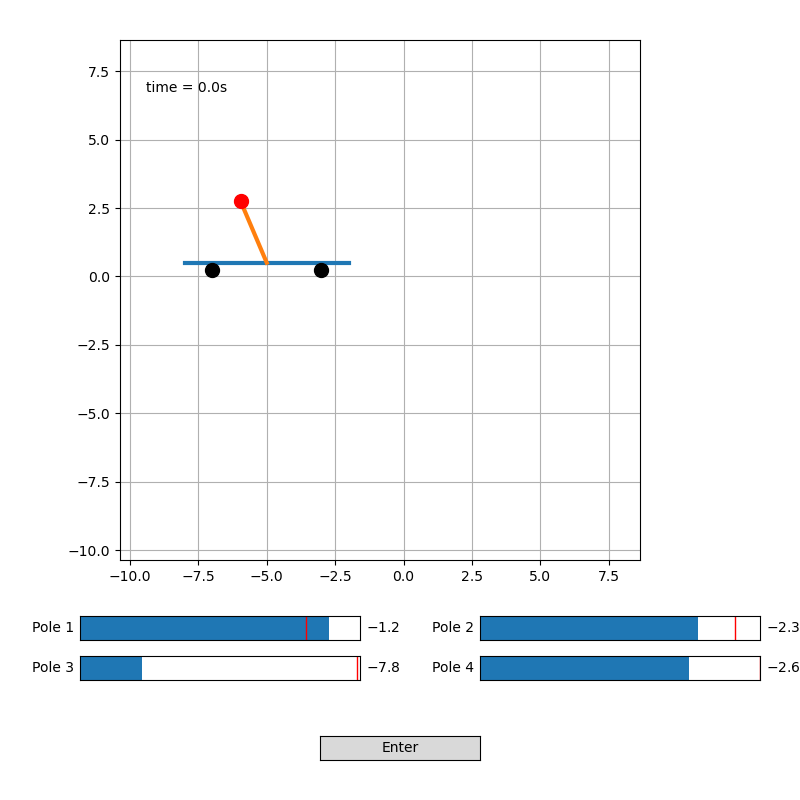

In [14]:
I = 0.006
m = 1       # Mass of the Pendulum
M = 5       # Mass of the Cart
L = 2       # Length of the Pendulum
g = -10     # Acc. Due to gravity
d = 1       # Damping

# Defining linearized state space model below and calculating state feedback control gains for optimal control

A = np.array([[0,1,0,0],[0,-d/M,-m*g/M,0],[0,0,0,1],[0,-d/(M+L),-(m+M)*g/(M+L),0]])
B = np.array([[0],[1/M],[0],[1/(M*L)]])
C = np.array([1,0,0,0])
D = np.array([0])
Q = np.matrix([[1,0,0,0],[0,1,0,0],[0,0,10,0],[0,0,0,100]])
R = 0.0001

[K,S,E] = co.lqr(A,B,Q,R)
Kf = np.array([K[0,0],K[0,1],K[0,2],K[0,3]])

# Initializing the first base run

y0 = np.array([-5,0,np.pi+0.5,0])
yd = np.array([0,0,np.pi,0])
yd_mat = np.matrix([[yd[0]],[yd[1]],[yd[2]],[yd[3]]])

#Creating time vector
T_final = 20
t = np.arange(0,T_final,0.1)

# Integrating and getting state vector
y = integrate.odeint(statespace,y0,t)

# Creating the Figure
fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot(111, aspect='equal', autoscale_on=False, position=[.15,.25,.65,.75] )
ax2.grid()

# setting the axis to the max displacement x so the whole cart is visible

ax2.set_xlim([-10,10])
ax2.set_ylim([-10,10])

# Drawing the parts of the system
cart_x = y[0,0]
cart, = ax2.plot([cart_x-3,cart_x+3],[0.5,0.5], linewidth = 3)
wheel1, = ax2.plot(cart_x-2,[0.25],'ok',ms = 10)
wheel2, = ax2.plot(cart_x+2,[0.25],'ok',ms = 10)

pend_x = cart_x + L*np.sin(y[0,2])
pend_y = 1 - L*np.cos(y[0,2])
pend_rod, = ax2.plot([cart_x,pend_x],[0.5,pend_y],linewidth = 3)
pend, = ax2.plot(pend_x,pend_y,'ro',ms = 10)

time_template = 'time = %.1fs'
time_text = ax2.text(0.05, 0.9, '', transform=ax2.transAxes)

ax_p1 = plt.axes([0.1, 0.2, 0.35, 0.03])
ax_p2 = plt.axes([0.6, 0.2, 0.35, 0.03])
ax_p3 = plt.axes([0.1, 0.15, 0.35, 0.03])
ax_p4 = plt.axes([0.6, 0.15, 0.35, 0.03])

ax_button = plt.axes([0.4, 0.05, 0.2, 0.03 ])



#Creating Sliders
s_p1 = Slider(ax_p1, r'Pole 1', -10, -0.1, valinit = -2, valstep = 0.1)
s_p2 = Slider(ax_p2, r'Pole 2', -10, -0.1, valinit = -1, valstep = 0.1)
s_p3 = Slider(ax_p3, r'Pole 3', -10, -0.1, valinit = -0.2, valstep = 0.1)
s_p4 = Slider(ax_p4, r'Pole 4', -10, -0.1, valinit = -0.1, valstep = 0.1)

# Creating Button 
button = Button(ax_button,'Enter')
button.on_clicked(update_button)

ani_k = FuncAnimation(fig2, animate,frames = len(t), interval=5, repeat = True)